# Paity analysis
basic: no forecast  
m: montly data

- usdjpy : "DEXJPUS","fred"

## purchasing power parity


### consumer price index

- "USACPIALLMINMEI","fred"
- "JPNCPIALLMINMEI","fred"

### purchasing price index

- "PPIACO","fred"
- "PITGCG01JPM661N","fred"

## interest rate parity
### 1month

- "USD1MTD156N","fred"
- "JPY1MTD156N","fred"

### 3 months

- "USD3MTD156N","fred"
- "JPY3MTD156N","fred"

### 6 months

- "USD6MTD156N","fred"
- "JPY6MTD156N","fred"

### 12 months

- "USD12MD156N","fred"
- "JPY12MD156N","fred"



In [1]:
%matplotlib inline
import datetime
import pandas_datareader.data as web
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
from statsmodels.tsa.api import VECM
start="1971/1/1";end='2019/12/31'
from dateutil.relativedelta import relativedelta
from scipy.stats import t
from scipy.stats import norm
def tcdf(x,n): #t-distribution
    if x>=0:
        y=(1-t.cdf(x,n))
    else:
        y=t.cdf(x,n)
    return y
def ncdf(x): #t-distribution
    if x>=0:
        y=(1-norm.cdf(x))
    else:
        y=norm.cdf(x)
    return y

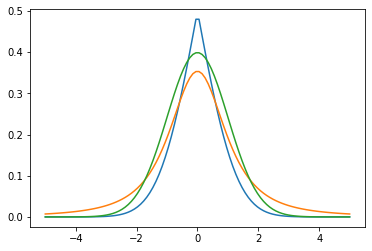

In [286]:
x=np.linspace(-5,5,100)
xxx=[]
for xx in x:
    xxx.append(ncdf(xx))
plt.plot(x,xxx)
xxx=[]
for xx in x:
    xxx.append(t.pdf(xx,2))
plt.plot(x,xxx)
xxx=[]
for xx in x:
    xxx.append(norm.pdf(xx))
plt.plot(x,xxx)


# CPI

In [287]:
e =web.DataReader("DEXJPUS","fred",start,end)
p1 =web.DataReader("USACPIALLMINMEI","fred",start,end)#m
p2 =web.DataReader("JPNCPIALLMINMEI","fred",start,end)#m

In [288]:
ee=e.copy().resample('MS').last()
tsd=pd.concat([ee,p1,p2],axis=1)
tsd.columns=['ee','p1','p2']
print(tsd.head())
print(tsd.tail())

                ee         p1    p2
DATE                               
1971-01-01  357.72  16.792044  32.8
1971-02-01  357.56  16.834236  32.8
1971-03-01  357.42  16.876427  32.9
1971-04-01  357.40  16.918618  33.3
1971-05-01  357.40  17.003000  33.4
                ee          p1     p2
DATE                                 
2019-08-01  106.30  108.244556  101.8
2019-09-01  108.11  108.329360  101.9
2019-10-01  108.09  108.577022  102.2
2019-11-01  109.47  108.518798  102.3
2019-12-01  108.67  108.420071  102.3


In [289]:
def backtest(tsd,tw,pt):#tw time window pt:predicting time
    pred=[]
    real0=[]
    real9=[]
    for i in range(tw,len(tsd)+1):
        y0=tsd.iloc[i-tw:i:1,0]
        x0=tsd.iloc[i-tw:i:1,2]/tsd.iloc[i-tw:i:1,1]
        a=(y0/x0).mean()
        real0.append(tsd.iloc[i-1:i,0][-1])
        if i<len(tsd)+1-pt:
            x9=tsd.iloc[i-1:i+pt:1,2]/tsd.iloc[i-1:i+pt:1,1]
            pred.append(a*x9.iloc[-1])
            real9.append(tsd.iloc[i+pt-1:i+pt:1,0].values)
    return real0,real9,pred

def performance_eval(real0,real9,pred):
    p0=pd.DataFrame(real0)
    p9=pd.DataFrame(real9)
    pp=pd.DataFrame(pred)
    p0_=p0[:len(p9)]
    pp_=pp[:len(p9)]
    wrs=p0_[(p9<p0_)&(pp_<p0_)].count()
    wrl=p0_[(p9>p0_)&(pp_>p0_)].count()
    wr=float((wrs+wrl)/p0_.count())
    #wrp=t.cdf(float((wr-0.5)/np.sqrt(0.25/p0_.count())),p0_.count())[0]
    wrp=ncdf(float((wr-0.5)/np.sqrt(0.25/p0_.count())))
    d_x=(pp_-p9)**2
    d_rw=(p9-p0_)**2
    d=d_x-d_rw
    d_=float(d.mean())
    #dm=tcdf(float(d_/np.sqrt(((d-d_)**2).sum()/len(d)**2)),p0_.count())[0]
    dm=ncdf(float(d_/np.sqrt(((d-d_)**2).sum()/len(d)**2)))
    #print(dm)
    rmse=float(d_x.mean()/d_rw.mean())
    return rmse,dm,wr,wrp

def performance_report(real0,real9,pred):
    ab,dm,wr,wrp=performance_eval(real0,real9,pred)
    print('{0:20s}{1:5d} mse_r {2:7.4f} mse_p {3:7.2f} wr {4:7.4f} wrp {5:7.2f} len {6:4d}'
          .format(model,isp,ab,dm,wr,wrp,len(real9)))    

In [292]:
pstart=datetime.date(1971,1,1)
pend=datetime.date(1982,12,31)        
model='none'
for oosp in [1,3,6,12,24,36,48,60]:#predicting time window
    nn=len(tsd.loc[pstart:pend])#available number of data point
    for isp in range(1,2,12):#10,pt):
        ps=pstart-relativedelta(months=isp*1-1)
        tsdd=tsd.loc[ps:pend]
        print(isp,pstart,ps)
        if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
            real0,real9,pred=backtest(tsdd,isp,oosp)
            print(oosp)
            performance_report(real0,real9,pred)

1 1971-01-01 1971-01-01
1
none                    1 mse_r  1.0422 mse_p    0.21 wr  0.4615 wrp    0.18 len  143
1 1971-01-01 1971-01-01
3
none                    1 mse_r  1.1335 mse_p    0.01 wr  0.4610 wrp    0.18 len  141
1 1971-01-01 1971-01-01
6
none                    1 mse_r  1.1630 mse_p    0.00 wr  0.3913 wrp    0.01 len  138
1 1971-01-01 1971-01-01
12
none                    1 mse_r  1.1795 mse_p    0.00 wr  0.4091 wrp    0.02 len  132
1 1971-01-01 1971-01-01
24
none                    1 mse_r  1.4122 mse_p    0.00 wr  0.3833 wrp    0.01 len  120
1 1971-01-01 1971-01-01
36
none                    1 mse_r  1.7186 mse_p    0.00 wr  0.4630 wrp    0.22 len  108
1 1971-01-01 1971-01-01
48
none                    1 mse_r  1.7485 mse_p    0.00 wr  0.4896 wrp    0.42 len   96
1 1971-01-01 1971-01-01
60
none                    1 mse_r  2.0437 mse_p    0.00 wr  0.5119 wrp    0.41 len   84


In [243]:
pstart=datetime.date(1983,1,1)
pend=datetime.date(1994,12,31)        
model='none'
for oosp in [1,3,6,12,24,36,48,60]:
    nn=len(tsd.loc[pstart:pend])
    for isp in range(1,2,12):#10,pt):
        ps=pstart-relativedelta(months=isp*1-1)
        tsdd=tsd.loc[ps:pend]
        if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
            real0,real9,pred=backtest(tsdd,isp,oosp)
            print(oosp)
            performance_report(real0,real9,pred)

1
none                    1 mse_r  1.0291 mse_p    0.14 wr  0.4825 wrp    0.34 len  143
3
none                    1 mse_r  0.9904 mse_p    0.36 wr  0.5248 wrp    0.28 len  141
6
none                    1 mse_r  0.9337 mse_p    0.00 wr  0.6377 wrp    0.00 len  138
12
none                    1 mse_r  0.8950 mse_p    0.00 wr  0.7576 wrp    0.00 len  132
24
none                    1 mse_r  0.7958 mse_p    0.00 wr  0.7750 wrp    0.00 len  120
36
none                    1 mse_r  0.7080 mse_p    0.00 wr  0.8148 wrp    0.00 len  108
48
none                    1 mse_r  0.6211 mse_p    0.00 wr  0.9375 wrp    0.00 len   96
60
none                    1 mse_r  0.5216 mse_p    0.00 wr  0.9881 wrp    0.00 len   84


In [245]:
pstart=datetime.date(1995,1,1)
pend=datetime.date(2007,12,31)        
model='none'
for oosp in [1,3,6,12,24,36,48,60]:
    nn=len(tsd.loc[pstart:pend])
    for isp in range(1,2,12):#10,pt):
        ps=pstart-relativedelta(months=isp*1-1)
        tsdd=tsd.loc[ps:pend]
        if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
            real0,real9,pred=backtest(tsdd,isp,oosp)
            print(oosp)
            performance_report(real0,real9,pred)

1
none                    1 mse_r  1.0406 mse_p    0.03 wr  0.4968 wrp    0.47 len  155
3
none                    1 mse_r  1.0940 mse_p    0.00 wr  0.4052 wrp    0.01 len  153
6
none                    1 mse_r  1.0921 mse_p    0.00 wr  0.4333 wrp    0.05 len  150
12
none                    1 mse_r  1.0931 mse_p    0.01 wr  0.4583 wrp    0.16 len  144
24
none                    1 mse_r  1.1138 mse_p    0.02 wr  0.4242 wrp    0.04 len  132
36
none                    1 mse_r  1.2293 mse_p    0.00 wr  0.4917 wrp    0.43 len  120
48
none                    1 mse_r  1.8507 mse_p    0.00 wr  0.5463 wrp    0.17 len  108
60
none                    1 mse_r  2.3644 mse_p    0.00 wr  0.5000 wrp    0.50 len   96


In [247]:
pstart=datetime.date(2008,1,1)
pend=datetime.date(2020,12,31)        
model='none'
for oosp in [1,3,6,12,24,36,48,60]:
    nn=len(tsd.loc[pstart:pend])
    for isp in range(1,2,12):#10,pt):
        ps=pstart-relativedelta(months=isp*1-1)
        tsdd=tsd.loc[ps:pend]
        if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
            real0,real9,pred=backtest(tsdd,isp,oosp)
            print(oosp)
            performance_report(real0,real9,pred)

1
none                    1 mse_r  1.0353 mse_p    0.09 wr  0.5105 wrp    0.40 len  143
3
none                    1 mse_r  1.0332 mse_p    0.20 wr  0.5603 wrp    0.08 len  141
6
none                    1 mse_r  0.9898 mse_p    0.38 wr  0.5942 wrp    0.01 len  138
12
none                    1 mse_r  0.9118 mse_p    0.00 wr  0.7197 wrp    0.00 len  132
24
none                    1 mse_r  0.8731 mse_p    0.00 wr  0.7667 wrp    0.00 len  120
36
none                    1 mse_r  0.9247 mse_p    0.00 wr  0.5926 wrp    0.03 len  108
48
none                    1 mse_r  1.0180 mse_p    0.28 wr  0.3021 wrp    0.00 len   96
60
none                    1 mse_r  1.2358 mse_p    0.00 wr  0.1667 wrp    0.00 len   84


# PPI

In [249]:
p1 =web.DataReader("PPIACO","fred",start,end)#m
p2 =web.DataReader("PITGCG01JPM661N","fred",start,end)#m
tsd=pd.concat([ee,p1,p2],axis=1)
tsd.columns=['ee','p1','p2']
print(tsd.head())
print(tsd.tail())
pstart=datetime.date(1983,1,1)
#pend=datetime.date(1995,12,31)        
pend=datetime.date(2020,12,31) 

                ee    p1         p2
DATE                               
1971-01-01  357.72  37.3  67.280863
1971-02-01  357.56  37.7  67.280863
1971-03-01  357.42  37.8  67.379515
1971-04-01  357.40  37.9  67.478167
1971-05-01  357.40  38.1  67.774124
                ee     p1    p2
DATE                           
2019-08-01  106.30  199.2  95.4
2019-09-01  108.11  198.4  95.5
2019-10-01  108.09  198.6  95.3
2019-11-01  109.47  199.0  95.3
2019-12-01  108.67  199.2  95.7


1
none                    1 mse_r  1.0896 mse_p    0.03 wr  0.5175 wrp    0.34 len  143
3
none                    1 mse_r  1.0450 mse_p    0.22 wr  0.5177 wrp    0.34 len  141
6
none                    1 mse_r  0.9739 mse_p    0.33 wr  0.5652 wrp    0.06 len  138
12
none                    1 mse_r  0.8319 mse_p    0.01 wr  0.5909 wrp    0.02 len  132
24
none                    1 mse_r  0.7659 mse_p    0.00 wr  0.5500 wrp    0.14 len  120
36
none                    1 mse_r  0.7195 mse_p    0.00 wr  0.7315 wrp    0.00 len  108
48
none                    1 mse_r  0.5460 mse_p    0.00 wr  0.8438 wrp    0.00 len   96
60
none                    1 mse_r  0.3045 mse_p    0.00 wr  0.9643 wrp    0.00 len   84


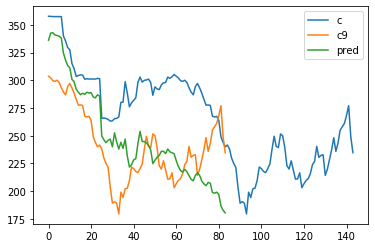

In [250]:
pstart=datetime.date(1971,1,1)
pend=datetime.date(1982,12,31)        
model='none'
for oosp in [1,3,6,12,24,36,48,60]:
    nn=len(tsd.loc[pstart:pend])
    for isp in range(1,2,12):#10,pt):
        ps=pstart-relativedelta(months=isp*1-1)
        tsdd=tsd.loc[ps:pend]
        if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
            real0,real9,pred=backtest(tsdd,isp,oosp)
            print(oosp)
            performance_report(real0,real9,pred)
plt.plot(real0[:],label='c')
plt.plot(real9[:],label='c9')
plt.plot(pred[:],label='pred')
plt.legend()

1
none                    1 mse_r  1.0014 mse_p    0.48 wr  0.5524 wrp    0.10 len  143
3
none                    1 mse_r  0.9685 mse_p    0.25 wr  0.5745 wrp    0.04 len  141
6
none                    1 mse_r  0.9561 mse_p    0.09 wr  0.6957 wrp    0.00 len  138
12
none                    1 mse_r  0.9734 mse_p    0.14 wr  0.6439 wrp    0.00 len  132
24
none                    1 mse_r  0.8868 mse_p    0.00 wr  0.6083 wrp    0.01 len  120
36
none                    1 mse_r  0.7701 mse_p    0.00 wr  0.7593 wrp    0.00 len  108
48
none                    1 mse_r  0.6227 mse_p    0.00 wr  0.9375 wrp    0.00 len   96
60
none                    1 mse_r  0.4777 mse_p    0.00 wr  0.9881 wrp    0.00 len   84


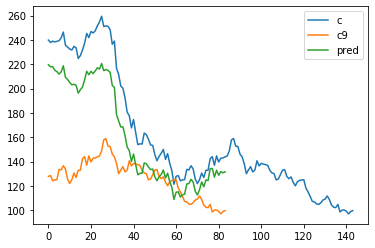

In [251]:
pstart=datetime.date(1983,1,1)
pend=datetime.date(1994,12,31)        
model='none'
for oosp in [1,3,6,12,24,36,48,60]:
    nn=len(tsd.loc[pstart:pend])
    for isp in range(1,2,12):#10,pt):
        ps=pstart-relativedelta(months=isp*1-1)
        tsdd=tsd.loc[ps:pend]
        if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
            real0,real9,pred=backtest(tsdd,isp,oosp)
            print(oosp)
            performance_report(real0,real9,pred)
plt.plot(real0[:],label='c')
plt.plot(real9[:],label='c9')
plt.plot(pred[:],label='pred')
plt.legend()

1
none                    1 mse_r  0.9760 mse_p    0.30 wr  0.5548 wrp    0.09 len  155
3
none                    1 mse_r  0.9810 mse_p    0.33 wr  0.5033 wrp    0.47 len  153
6
none                    1 mse_r  1.0259 mse_p    0.30 wr  0.5400 wrp    0.16 len  150
12
none                    1 mse_r  1.0544 mse_p    0.20 wr  0.4931 wrp    0.43 len  144
24
none                    1 mse_r  1.1075 mse_p    0.08 wr  0.4470 wrp    0.11 len  132
36
none                    1 mse_r  1.3415 mse_p    0.00 wr  0.5000 wrp    0.50 len  120
48
none                    1 mse_r  2.7379 mse_p    0.00 wr  0.5463 wrp    0.17 len  108
60
none                    1 mse_r  3.5825 mse_p    0.00 wr  0.5000 wrp    0.50 len   96


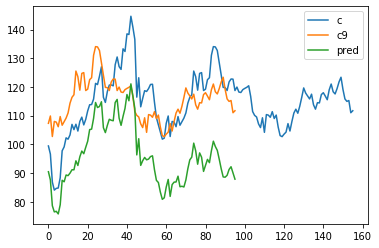

In [252]:
pstart=datetime.date(1995,1,1)
pend=datetime.date(2007,12,31)        
model='none'
for oosp in [1,3,6,12,24,36,48,60]:
    nn=len(tsd.loc[pstart:pend])
    for isp in range(1,2,12):#10,pt):
        ps=pstart-relativedelta(months=isp*1-1)
        tsdd=tsd.loc[ps:pend]
        if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
            real0,real9,pred=backtest(tsdd,isp,oosp)
            print(oosp)
            performance_report(real0,real9,pred)
plt.plot(real0[:],label='c')
plt.plot(real9[:],label='c9')
plt.plot(pred[:],label='pred')
plt.legend()

1
none                    1 mse_r  1.0625 mse_p    0.27 wr  0.5944 wrp    0.01 len  143
3
none                    1 mse_r  1.1405 mse_p    0.19 wr  0.6809 wrp    0.00 len  141
6
none                    1 mse_r  1.0773 mse_p    0.31 wr  0.6159 wrp    0.00 len  138
12
none                    1 mse_r  0.8763 mse_p    0.07 wr  0.6364 wrp    0.00 len  132
24
none                    1 mse_r  0.7184 mse_p    0.00 wr  0.7833 wrp    0.00 len  120
36
none                    1 mse_r  0.7011 mse_p    0.00 wr  0.7593 wrp    0.00 len  108
48
none                    1 mse_r  0.8085 mse_p    0.00 wr  0.7188 wrp    0.00 len   96
60
none                    1 mse_r  1.0544 mse_p    0.17 wr  0.5595 wrp    0.14 len   84


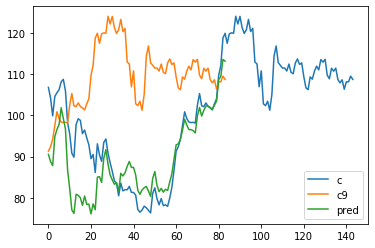

In [253]:
pstart=datetime.date(2008,1,1)
pend=datetime.date(2020,12,31)        
model='none'
for oosp in [1,3,6,12,24,36,48,60]:
    nn=len(tsd.loc[pstart:pend])
    for isp in range(1,2,12):#10,pt):
        ps=pstart-relativedelta(months=isp*1-1)
        tsdd=tsd.loc[ps:pend]
        if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
            real0,real9,pred=backtest(tsdd,isp,oosp)
            print(oosp)
            performance_report(real0,real9,pred)
plt.plot(real0[:],label='c')
plt.plot(real9[:],label='c9')
plt.plot(pred[:],label='pred')
plt.legend()

# irp 

In [254]:
start="1989/1/1";end='2019/12/31'
e =web.DataReader("DEXJPUS","fred",start,end)
r1 =web.DataReader("gs10","fred",start,end)#q
r2 =web.DataReader("IRLTLT01JPM156N","fred",start,end)#q

In [255]:
e.head(1),r1.head(1),r2.head(1)

(            DEXJPUS
 DATE               
 1989-01-02      NaN,             gs10
 DATE            
 1989-01-01  9.09,             IRLTLT01JPM156N
 DATE                       
 1989-01-01              4.8)

In [256]:
ee=e.copy().resample('MS').last()
tsd=pd.concat([ee,r1,r2],axis=1)
tsd.columns=['ee','r1','r2']
print(tsd.head())
print(tsd.tail())
pstart=datetime.date(1989,1,1)
#pend=datetime.date(1995,12,31)        
pend=datetime.date(2020,12,31)        

                ee    r1     r2
DATE                           
1989-01-01  130.50  9.09  4.800
1989-02-01  126.87  9.17  4.894
1989-03-01  132.77  9.36  5.147
1989-04-01  132.85  9.18  5.221
1989-05-01  142.33  8.86  5.174
                ee    r1     r2
DATE                           
2019-08-01  106.30  1.63 -0.280
2019-09-01  108.11  1.70 -0.215
2019-10-01  108.09  1.71 -0.150
2019-11-01  109.47  1.81 -0.080
2019-12-01  108.67  1.86 -0.025


In [257]:
def backtest(tsd,tw,pt):#tw time window pt:predicting time
    pred=[]
    real0=[]
    real9=[]
    for i in range(tw+1,len(tsd)+1-1):
        yy=tsd.iloc[i-tw:i:1,0]
        y0=tsd.iloc[i-tw:i:1,0]
        x0=((1+tsd.iloc[i-tw:i:1,2]/100)/(1+tsd.iloc[i-tw:i:1,1]/100))**(1/12*pt)
        real0.append(tsd.iloc[i-1:i,0][-1])
        if i<len(tsd)+1-pt:
            pred.append(y0.values*x0.values)
            real9.append(tsd.iloc[i+pt-1:i+pt:1,0].values[0])
    return real0,real9,pred

In [258]:
pstart=datetime.date(1989,1,1)
pend=datetime.date(2007,12,31)        
model='none'
for oosp in [120]:
    nn=len(tsd.loc[pstart:pend])
    for isp in range(1,2,12):#10,pt):
        ps=pstart-relativedelta(months=isp*1-1)
        tsdd=tsd.loc[ps:pend]
        if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
            real0,real9,pred=backtest(tsdd,isp,oosp)
            print(oosp)
            performance_report(real0,real9,pred)

120
none                    1 mse_r  2.1805 mse_p    0.00 wr  0.5140 wrp    0.39 len  107


In [260]:
pstart=datetime.date(2008,1,1)
pend=datetime.date(2020,12,31)        
model='none'
for oosp in [120]:
    nn=len(tsd.loc[pstart:pend])
    for isp in range(1,2,12):#10,pt):
        ps=pstart-relativedelta(months=isp*1-1)
        tsdd=tsd.loc[ps:pend]
        if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
            real0,real9,pred=backtest(tsdd,isp,oosp)
            print(oosp)
            performance_report(real0,real9,pred)

120
none                    1 mse_r  5.0816 mse_p    0.00 wr  0.0000 wrp    0.00 len   23


# irs 1m

In [262]:
start="1986/1/1";end='2019/12/31'
e =web.DataReader("DEXJPUS","fred",start,end)
r1 =web.DataReader("USD1MTD156N","fred",start,end)#q
r2 =web.DataReader("JPY1MTD156N","fred",start,end)#q
ee=e.copy().resample('MS').last()
rr1=r1.copy().resample('MS').last()
rr2=r2.copy().resample('MS').last()
tsd=pd.concat([ee,rr1,rr2],axis=1)
tsd.columns=['ee','r1','r2']
print(tsd.head())
print(tsd.tail())
pstart=datetime.date(1989,1,1)
pend=datetime.date(2020,12,31)      

                ee      r1      r2
DATE                              
1986-01-01  192.30  8.0625  6.4375
1986-02-01  180.55  7.9375  6.6250
1986-03-01  177.60  7.5000  5.6250
1986-04-01  167.60  6.9375  5.0000
1986-05-01  174.50  7.1250  4.8750
                ee       r1       r2
DATE                                
2019-08-01  106.30  2.08900 -0.12567
2019-09-01  108.11  2.01563 -0.10867
2019-10-01  108.09  1.78488 -0.11167
2019-11-01  109.47  1.69713 -0.19100
2019-12-01  108.67  1.76250 -0.08467


In [263]:
pstart=datetime.date(1986,1,1)
pend=datetime.date(1994,12,31)        
model='none'
for oosp in [1]:
    nn=len(tsd.loc[pstart:pend])
    for isp in range(1,2,12):#10,pt):
        ps=pstart-relativedelta(months=isp*1-1)
        tsdd=tsd.loc[ps:pend]
        if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
            real0,real9,pred=backtest(tsdd,isp,oosp)
            print(oosp)
            performance_report(real0,real9,pred)

1
none                    1 mse_r  0.9962 mse_p    0.38 wr  0.4434 wrp    0.12 len  106


In [265]:
pstart=datetime.date(1995,1,1)
pend=datetime.date(2007,12,31)        
model='none'
for oosp in [1]:
    nn=len(tsd.loc[pstart:pend])
    for isp in range(1,2,12):#10,pt):
        ps=pstart-relativedelta(months=isp*1-1)
        tsdd=tsd.loc[ps:pend]
        if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
            real0,real9,pred=backtest(tsdd,isp,oosp)
            print(oosp)
            performance_report(real0,real9,pred)

1
none                    1 mse_r  1.0187 mse_p    0.16 wr  0.4610 wrp    0.17 len  154


In [266]:
pstart=datetime.date(2008,1,1)
pend=datetime.date(2020,12,31)        
model='none'
for oosp in [1]:
    nn=len(tsd.loc[pstart:pend])
    for isp in range(1,2,12):#10,pt):
        ps=pstart-relativedelta(months=isp*1-1)
        tsdd=tsd.loc[ps:pend]
        if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
            real0,real9,pred=backtest(tsdd,isp,oosp)
            print(oosp)
            performance_report(real0,real9,pred)

1
none                    1 mse_r  0.9947 mse_p    0.17 wr  0.5282 wrp    0.25 len  142


# irs 3m

In [267]:
r1 =web.DataReader("USD3MTD156N","fred",start,end)#q
r2 =web.DataReader("JPY3MTD156N","fred",start,end)#q
rr1=r1.copy().resample('MS').last()
rr2=r2.copy().resample('MS').last()
tsd=pd.concat([ee,rr1,rr2],axis=1)
tsd.columns=['ee','r1','r2']
print(tsd.head())
print(tsd.tail())

                ee      r1     r2
DATE                             
1986-01-01  192.30  8.0625  6.250
1986-02-01  180.55  7.8750  6.000
1986-03-01  177.60  7.4375  5.375
1986-04-01  167.60  6.8750  4.875
1986-05-01  174.50  7.1250  4.875
                ee       r1       r2
DATE                                
2019-08-01  106.30  2.13763 -0.09200
2019-09-01  108.11  2.08513 -0.09917
2019-10-01  108.09  1.90225 -0.11500
2019-11-01  109.47  1.90550 -0.08350
2019-12-01  108.67  1.90838 -0.04733


In [268]:
pstart=datetime.date(1986,1,1)
pend=datetime.date(1994,12,31)        
model='none'
for oosp in [3]:
    nn=len(tsd.loc[pstart:pend])
    for isp in range(1,2,12):#10,pt):
        ps=pstart-relativedelta(months=isp*1-1)
        tsdd=tsd.loc[ps:pend]
        if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
            real0,real9,pred=backtest(tsdd,isp,oosp)
            print(oosp)
            performance_report(real0,real9,pred)

3
none                    1 mse_r  0.9909 mse_p    0.33 wr  0.4712 wrp    0.28 len  104


In [269]:
pstart=datetime.date(1995,1,1)
pend=datetime.date(2007,12,31)        
model='none'
for oosp in [1]:
    nn=len(tsd.loc[pstart:pend])
    for isp in range(1,2,12):#10,pt):
        ps=pstart-relativedelta(months=isp*1-1)
        tsdd=tsd.loc[ps:pend]
        if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
            real0,real9,pred=backtest(tsdd,isp,oosp)
            print(oosp)
            performance_report(real0,real9,pred)

1
none                    1 mse_r  1.0188 mse_p    0.16 wr  0.4610 wrp    0.17 len  154


In [270]:
pstart=datetime.date(2008,1,1)
pend=datetime.date(2020,12,31)        
model='none'
for oosp in [3]:
    nn=len(tsd.loc[pstart:pend])
    for isp in range(1,2,12):#10,pt):
        ps=pstart-relativedelta(months=isp*1-1)
        tsdd=tsd.loc[ps:pend]
        if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
            real0,real9,pred=backtest(tsdd,isp,oosp)
            print(oosp)
            performance_report(real0,real9,pred)

3
none                    1 mse_r  0.9900 mse_p    0.16 wr  0.5214 wrp    0.31 len  140


# irs 6m

In [271]:
r1 =web.DataReader("USD6MTD156N","fred",start,end)#q
r2 =web.DataReader("JPY6MTD156N","fred",start,end)#q
rr1=r1.copy().resample('MS').last()
rr2=r2.copy().resample('MS').last()
tsd=pd.concat([ee,rr1,rr2],axis=1)
tsd.columns=['ee','r1','r2']
print(tsd.head())
print(tsd.tail())

                ee      r1      r2
DATE                              
1986-01-01  192.30  8.1250  6.1875
1986-02-01  180.55  7.8750  5.6875
1986-03-01  177.60  7.4375  5.2500
1986-04-01  167.60  6.8750  4.7500
1986-05-01  174.50  7.1875  4.8750
                ee       r1       r2
DATE                                
2019-08-01  106.30  2.03650 -0.04950
2019-09-01  108.11  2.05563 -0.05083
2019-10-01  108.09  1.91625 -0.04750
2019-11-01  109.47  1.89688 -0.01167
2019-12-01  108.67  1.91213  0.01800


In [272]:
pstart=datetime.date(1986,1,1)
pend=datetime.date(1995,12,31)        
model='none'
for oosp in [6]:
    nn=len(tsd.loc[pstart:pend])
    for isp in range(1,2,12):#10,pt):
        ps=pstart-relativedelta(months=isp*1-1)
        tsdd=tsd.loc[ps:pend]
        if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
            real0,real9,pred=backtest(tsdd,isp,oosp)
            print(oosp)
            performance_report(real0,real9,pred)

6
none                    1 mse_r  0.9944 mse_p    0.42 wr  0.5487 wrp    0.15 len  113


In [273]:
pstart=datetime.date(1995,1,1)
pend=datetime.date(2007,12,31)        
model='none'
for oosp in [1]:
    nn=len(tsd.loc[pstart:pend])
    for isp in range(1,2,12):#10,pt):
        ps=pstart-relativedelta(months=isp*1-1)
        tsdd=tsd.loc[ps:pend]
        if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
            real0,real9,pred=backtest(tsdd,isp,oosp)
            print(oosp)
            performance_report(real0,real9,pred)

1
none                    1 mse_r  1.0185 mse_p    0.16 wr  0.4610 wrp    0.17 len  154


In [274]:
pstart=datetime.date(2008,1,1)
pend=datetime.date(2020,12,31)        
model='none'
for oosp in [6]:
    nn=len(tsd.loc[pstart:pend])
    for isp in range(1,2,12):#10,pt):
        ps=pstart-relativedelta(months=isp*1-1)
        tsdd=tsd.loc[ps:pend]
        if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
            real0,real9,pred=backtest(tsdd,isp,oosp)
            print(oosp)
            performance_report(real0,real9,pred)

6
none                    1 mse_r  0.9828 mse_p    0.07 wr  0.4818 wrp    0.33 len  137


# irs 12m

In [275]:
r1 =web.DataReader("USD12MD156N","fred",start,end)#q
r2 =web.DataReader("JPY12MD156N","fred",start,end)#q
rr1=r1.copy().resample('MS').last()
rr2=r2.copy().resample('MS').last()
tsd=pd.concat([ee,rr1,rr2],axis=1)#.dropna(how='any')
tsd.columns=['ee','r1','r2']
print(tsd.head())
print(tsd.tail())

                ee      r1      r2
DATE                              
1986-01-01  192.30  8.2500  6.1563
1986-02-01  180.55  7.9375  5.6250
1986-03-01  177.60  7.4375  5.1875
1986-04-01  167.60  6.9375  4.7500
1986-05-01  174.50  7.3750  5.0000
                ee       r1       r2
DATE                                
2019-08-01  106.30  1.97400  0.03600
2019-09-01  108.11  2.03213  0.02550
2019-10-01  108.09  1.95538  0.04383
2019-11-01  109.47  1.95213  0.10050
2019-12-01  108.67  1.99625  0.10483


In [276]:
pstart=datetime.date(1986,1,1)
pend=datetime.date(1994,12,31)        
model='none'
for oosp in [12]:
    nn=len(tsd.loc[pstart:pend])
    for isp in range(1,2,12):#10,pt):
        ps=pstart-relativedelta(months=isp*1-1)
        tsdd=tsd.loc[ps:pend]
        if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
            real0,real9,pred=backtest(tsdd,isp,oosp)
            print(oosp)
            performance_report(real0,real9,pred)

12
none                    1 mse_r  0.9957 mse_p    0.47 wr  0.5579 wrp    0.13 len   95


In [277]:
pstart=datetime.date(1995,1,1)
pend=datetime.date(2007,12,31)        
model='none'
for oosp in [1]:
    nn=len(tsd.loc[pstart:pend])
    for isp in range(1,2,12):#10,pt):
        ps=pstart-relativedelta(months=isp*1-1)
        tsdd=tsd.loc[ps:pend]
        if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
            real0,real9,pred=backtest(tsdd,isp,oosp)
            print(oosp)
            performance_report(real0,real9,pred)

1
none                    1 mse_r  1.0186 mse_p    0.16 wr  0.4610 wrp    0.17 len  154


In [278]:
pstart=datetime.date(2008,1,1)
pend=datetime.date(2020,12,31)        
model='none'
for oosp in [12]:
    nn=len(tsd.loc[pstart:pend])
    for isp in range(1,2,12):#10,pt):
        ps=pstart-relativedelta(months=isp*1-1)
        tsdd=tsd.loc[ps:pend]
        if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
            real0,real9,pred=backtest(tsdd,isp,oosp)
            print(oosp)
            performance_report(real0,real9,pred)

12
none                    1 mse_r  0.9776 mse_p    0.05 wr  0.5573 wrp    0.10 len  131
